<a href="https://colab.research.google.com/github/StetskoSergey/pida5_stetsko/blob/master/6%20homework%20auc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc 

In [21]:
# Загружаем данные и переводим целевой столбец в 0 и 1
data = pd.read_csv('adult.csv')
data['target'] = data['income'].apply(lambda x: 0 if x=='<=50K' else 1) 
data = data.drop(columns=['income'])
data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,target
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,0


In [0]:
# Нужно привести список стран к количеству не более 20 например,
# для этого выведем список самых частых стран, а остальные приведем к значению "прочие"
from collections import Counter
spisok_osn_stran = [i[0] for i in Counter(data['native-country']).most_common()[:20]]
data['native-country'] = data['native-country'].apply(lambda x: (x if x!='?' else 'norhing') if x in spisok_osn_stran else 'another')

In [73]:
#Находим категориальные признаки
cat_feat = list(data.dtypes[data.dtypes == object].index)
print('Категориальные признаки \n',cat_feat)

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
data[cat_feat] = data[cat_feat].fillna('nan')

#отфильтруем непрерывные признаки
num_feat = [f for f in data if f not in (cat_feat + ['index', 'target'])]
print('Непрерывные признаки \n', num_feat)

# Смотрим сколько у нас значений по каждому категориальному признаку
cat_nunique = data[cat_feat].nunique()
print(cat_nunique)

#Чтобы в разы не увеличивать число признаков при построении dummy,
#будем использовать категориальные признаки с < 30 уникальных значений
cat_feat = list(cat_nunique[cat_nunique < 30].index)

Категориальные признаки 
 ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
Непрерывные признаки 
 ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
workclass          9
education         16
marital-status     7
occupation        15
relationship       6
race               5
gender             2
native-country    21
dtype: int64


In [0]:
# Создаем дамми-переменные для категорий
dummy_train = pd.get_dummies(data[cat_feat], columns=cat_feat)

dummy_cols = list(set(dummy_train))

dummy_train = dummy_train[dummy_cols]

# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
X = pd.concat([data[num_feat].fillna(-999),
                     dummy_train], axis=1)
train_median = data[num_feat].median()
X = pd.concat([data[num_feat].fillna(train_median),
                     data[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_train], axis=1)

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit
# Разбиваем на train/test
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=777)

for train_index, test_index in splitter.split(X, np.zeros(X.shape[0])):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
        
    y_train = data.iloc[train_index]['target']
    y_test = data.iloc[test_index]['target']

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [0]:
# делаем нормализацию данных
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train[num_feat])
X_train = pd.concat([pd.DataFrame(scaler.transform(X_train[num_feat]), columns = num_feat), X_train.drop(columns = num_feat)], axis = 1)
X_test = pd.concat([pd.DataFrame(scaler.transform(X_test[num_feat]), columns = num_feat), X_test.drop(columns = num_feat)], axis = 1)

In [98]:
X_train.head()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,age_NaN,fnlwgt_NaN,educational-num_NaN,capital-gain_NaN,capital-loss_NaN,hours-per-week_NaN,workclass_NaN,education_NaN,marital-status_NaN,occupation_NaN,relationship_NaN,race_NaN,gender_NaN,native-country_NaN,occupation_Other-service,native-country_Jamaica,workclass_Self-emp-not-inc,occupation_Craft-repair,relationship_Husband,marital-status_Separated,relationship_Not-in-family,gender_Female,gender_Male,native-country_Italy,native-country_South,native-country_Philippines,education_Some-college,workclass_Without-pay,native-country_Cuba,marital-status_Married-civ-spouse,workclass_Private,marital-status_Widowed,native-country_India,education_Prof-school,...,workclass_Never-worked,education_12th,race_Black,native-country_United-States,occupation_Protective-serv,relationship_Other-relative,workclass_Federal-gov,occupation_Adm-clerical,education_1st-4th,native-country_Canada,education_7th-8th,occupation_Farming-fishing,race_Amer-Indian-Eskimo,relationship_Wife,native-country_Dominican-Republic,education_Assoc-acdm,race_White,education_10th,occupation_Exec-managerial,workclass_State-gov,marital-status_Married-AF-spouse,occupation_?,native-country_El-Salvador,native-country_Japan,education_9th,education_Doctorate,native-country_Mexico,occupation_Handlers-cleaners,occupation_Sales,race_Other,native-country_norhing,native-country_Germany,occupation_Prof-specialty,workclass_?,education_Masters,education_HS-grad,education_Preschool,education_Assoc-voc,education_5th-6th,workclass_Self-emp-inc
0,-1.215942,0.100829,1.132487,-0.144946,-0.218907,-2.046860,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,-1.070105,-0.482521,0.744015,-0.144946,-0.218907,-0.840062,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0.971603,0.082542,-1.586816,-0.144946,-0.218907,-0.035529,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.752849,0.061335,1.132487,-0.144946,-0.218907,-0.437795,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.534094,-0.716923,-0.032929,-0.144946,-0.218907,-0.196435,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [136]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
predictions = lr.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, predictions[:, 1])
roc_auc = auc(fpr, tpr)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


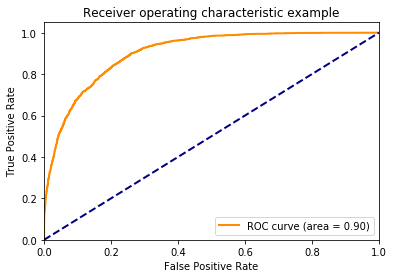

In [137]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [0]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
predictions = rf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, predictions[:, 1])
roc_auc = auc(fpr, tpr)

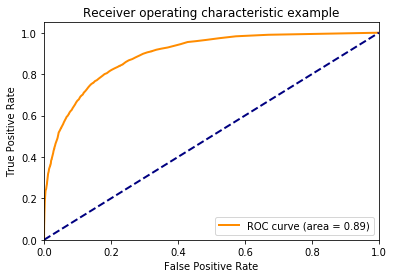

In [141]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()